# Tarea Semanal 5: Estimación espectral: Ancho de banda de señales reales

Se nos presentan 3 tipos de señales: 

-Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
-Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
-Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

Todas estas son muestras tomadas de su correspondiente dispositivo de medicion. El objetivo es estimar su ancho de banda de cada una de las señales presentadas.

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.



In [78]:
import numpy as np
from scipy import signal as sig
import pandas as pd
import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
import sounddevice as sd

from scipy import signal
from scipy.fft import fft, fftshift
import pandas as pd
rng = np.random.default_rng()

In [79]:
#Funciones

def blackman_tukey(x,  M = None):    
    
    # N = len(x)
    x_z = x.shape
    
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1

    # hay que aplanar los arrays por np.correlate.
    # usaremos el modo same que simplifica el tratamiento
    # de la autocorr
    xx = x.ravel()[:r_len];

    r = np.correlate(xx, xx, mode='same') / r_len

    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N) )

    Px = Px.reshape(x_z)

    return Px;

# Metodo
Primero se carga el archivo npy con los datos del ecg, se hace una medicion del numero de muestras para poder obtener la resolucion espectral de la señal, ademas de que se normaliza en potencia. Luego se aplicaron los metodos de welch y blackman-tukey para la estimacion espectral 

# ECG

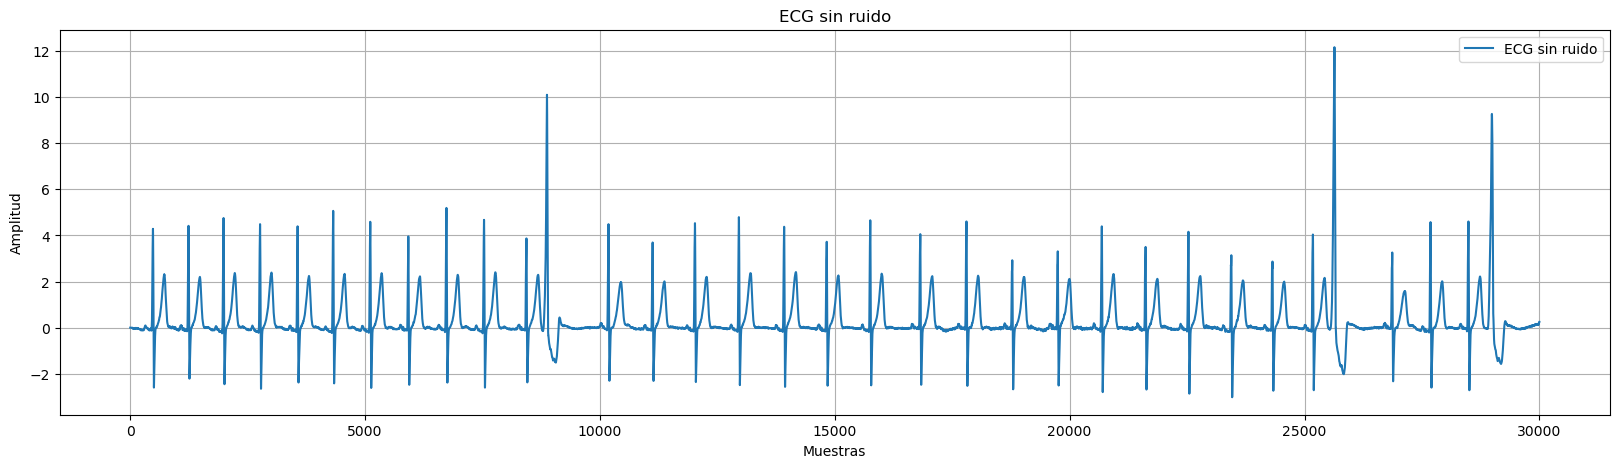

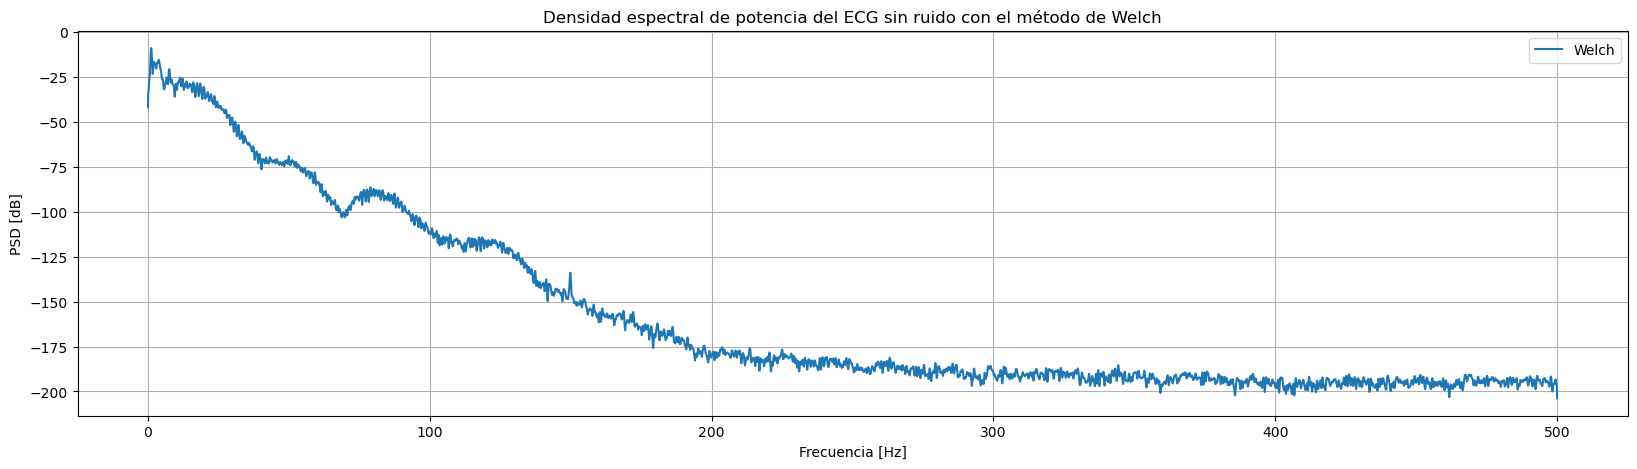

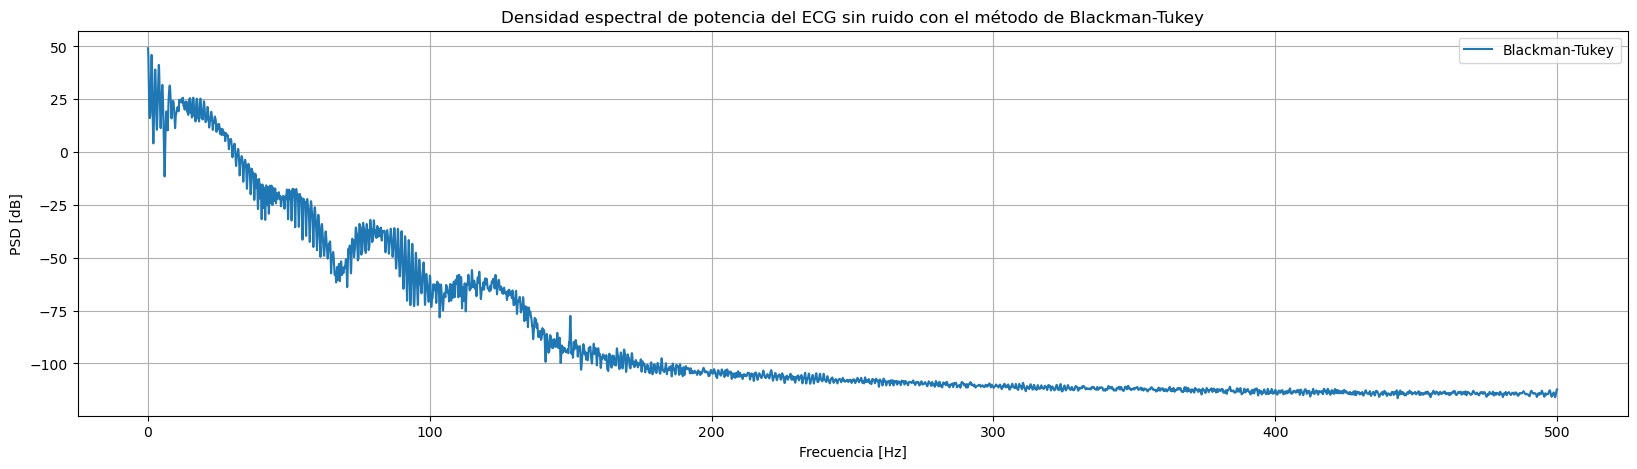

In [80]:
fs_ecg = 1000 # Hz # Hz

# para listar las variables que hay en el archivo
ecg_sin_ruido = np.load('./ecg_sin_ruido.npy') # cargar el archivo . npy

N = len(ecg_sin_ruido) # Número de muestras
df = fs_ecg/N
ff= np.linspace(0, fs_ecg, N, endpoint=False)
nor_ecg = ecg_sin_ruido / np.std(ecg_sin_ruido) # normalizamos el ECG

fw_ecg, Pxxw_ecg = signal.welch(nor_ecg, fs_ecg, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD
Pxxbt_ecg = blackman_tukey(nor_ecg, M=int(N//8)) # uso el metodo de Blackman-Tukey para calcular la PSD
ff_ecg = ff[:len(Pxxbt_ecg)//2] # vector de frecuencias para el método de Blackman-Tukey

plt.figure(1,figsize=(20, 5))
plt.plot(nor_ecg, label='ECG sin ruido')
plt.title('ECG sin ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_ecg,10*np.log10(2*np.abs(Pxxw_ecg)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

plt.figure(3,figsize=(20, 5))
plt.plot(ff_ecg, 10*np.log10(np.abs(Pxxbt_ecg[:len(Pxxbt_ecg)//2])**2), label='Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

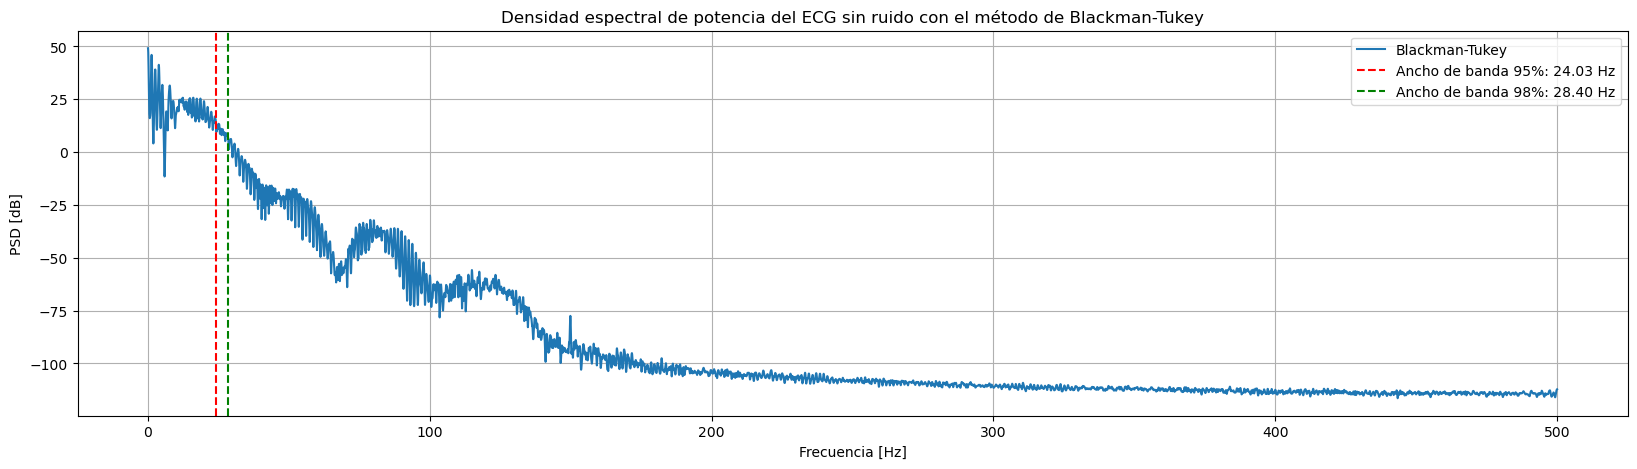

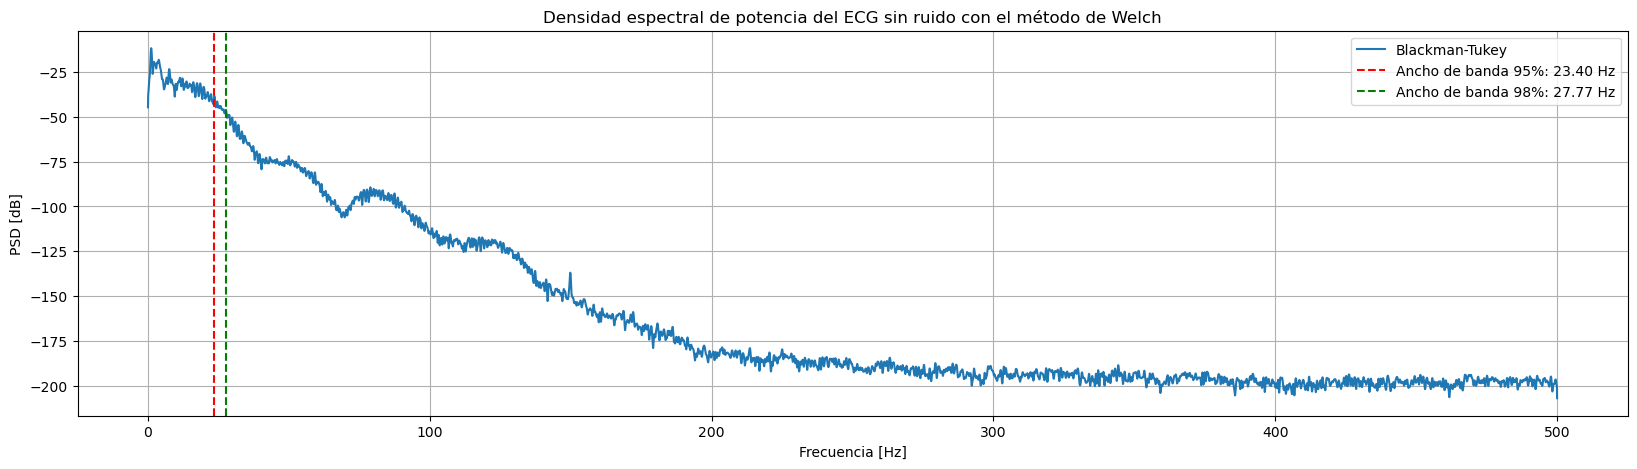

In [81]:
# Trabajamos solo con la mitad del espectro (parte positiva)

energia_total_bt_ecg=np.sum(Pxxbt_ecg[:len(Pxxbt_ecg)//2]) # La energia total del ECG espectro
energia_acumulada_bt_ecg=np.cumsum(Pxxbt_ecg[:len(Pxxbt_ecg)//2]) # La energia acumulada del ECG espectro
indx_95=np.where(energia_acumulada_bt_ecg>=0.95*energia_total_bt_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_98=np.where(energia_acumulada_bt_ecg>=0.98*energia_total_bt_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
ancho_banda_95_ecg_bt=ff_ecg[indx_95] # El ancho de banda del ECG espectro
ancho_banda_98_ecg_bt=ff_ecg[indx_98] # El ancho de banda del ECG espectro

plt.figure(3,figsize=(20, 5))
plt.plot(ff_ecg, 10*np.log10(np.abs(Pxxbt_ecg[:len(Pxxbt_ecg)//2])**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_ecg_bt, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_bt:.2f} Hz')
plt.axvline(x=ancho_banda_98_ecg_bt, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_bt:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()


energia_total_w_ecg=np.sum(Pxxw_ecg) # La energia total del ECG espectro
energia_acumulada_w_ecg=np.cumsum(Pxxw_ecg) # La energia acumulada del ECG espectro
indx_95_w_ecg=np.where(energia_acumulada_w_ecg>=0.95*energia_total_w_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_98_w_ecg=np.where(energia_acumulada_w_ecg>=0.98*energia_total_w_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
ancho_banda_95_ecg_w=ff_ecg[indx_95_w_ecg] # El ancho de banda del ECG espectro
ancho_banda_98_ecg_w=ff_ecg[indx_98_w_ecg] # El ancho de banda del ECG espectro

plt.figure(3,figsize=(20, 5))
plt.plot(fw_ecg, 10*np.log10(np.abs(Pxxw_ecg)**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_ecg_w, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_w:.2f} Hz')
plt.axvline(x=ancho_banda_98_ecg_w, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_w:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

# PPG

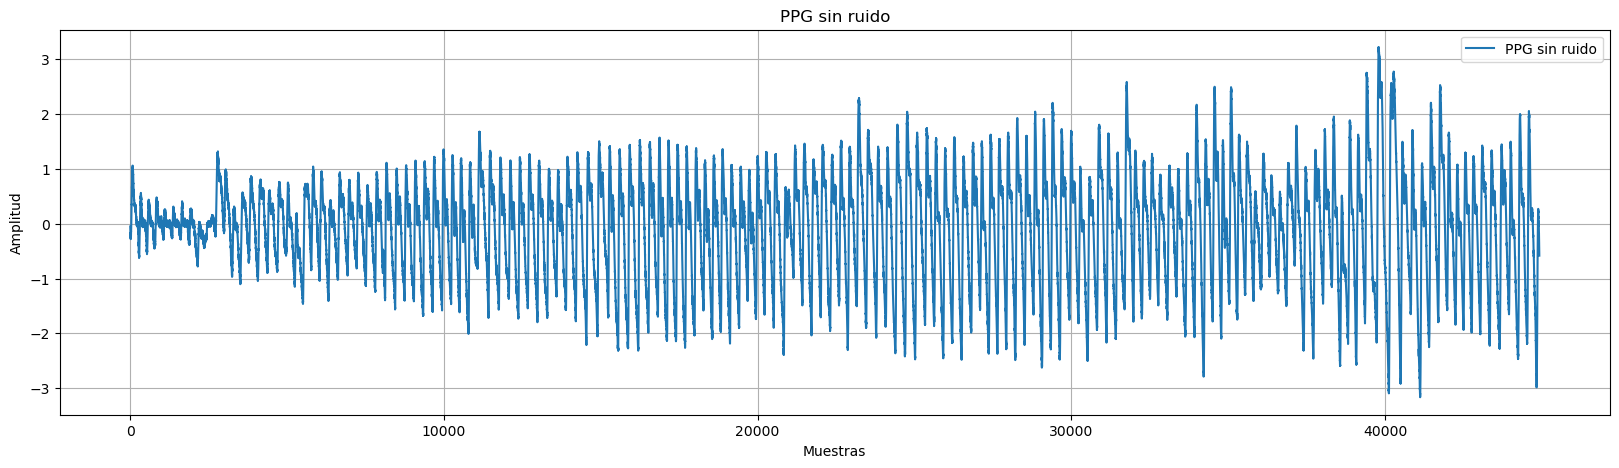

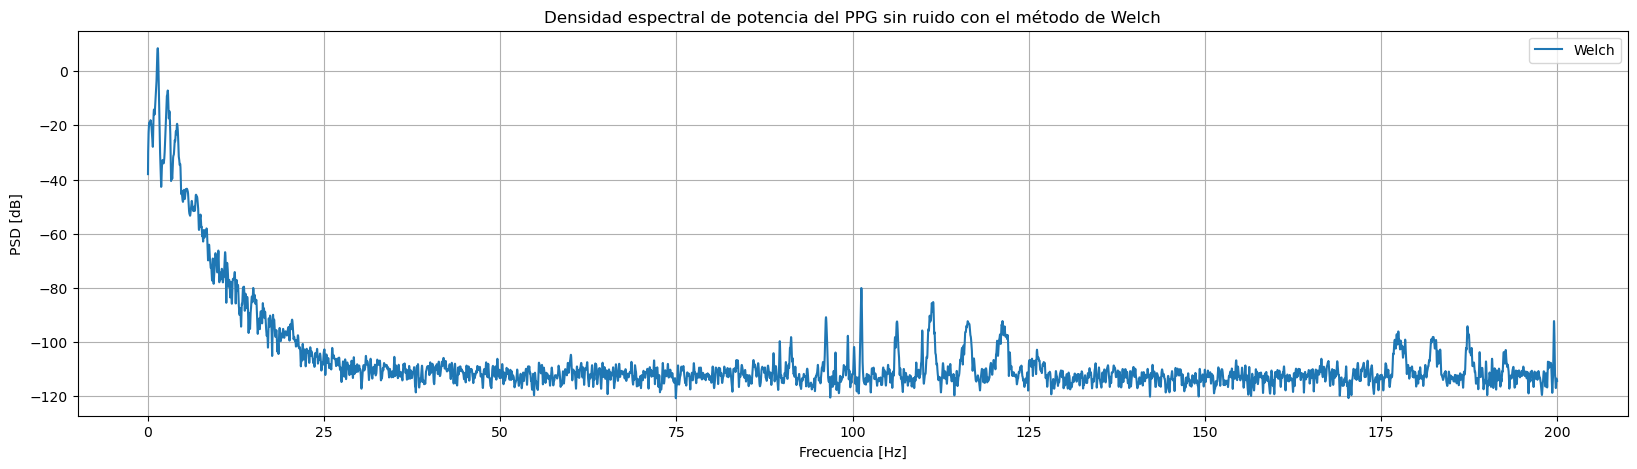

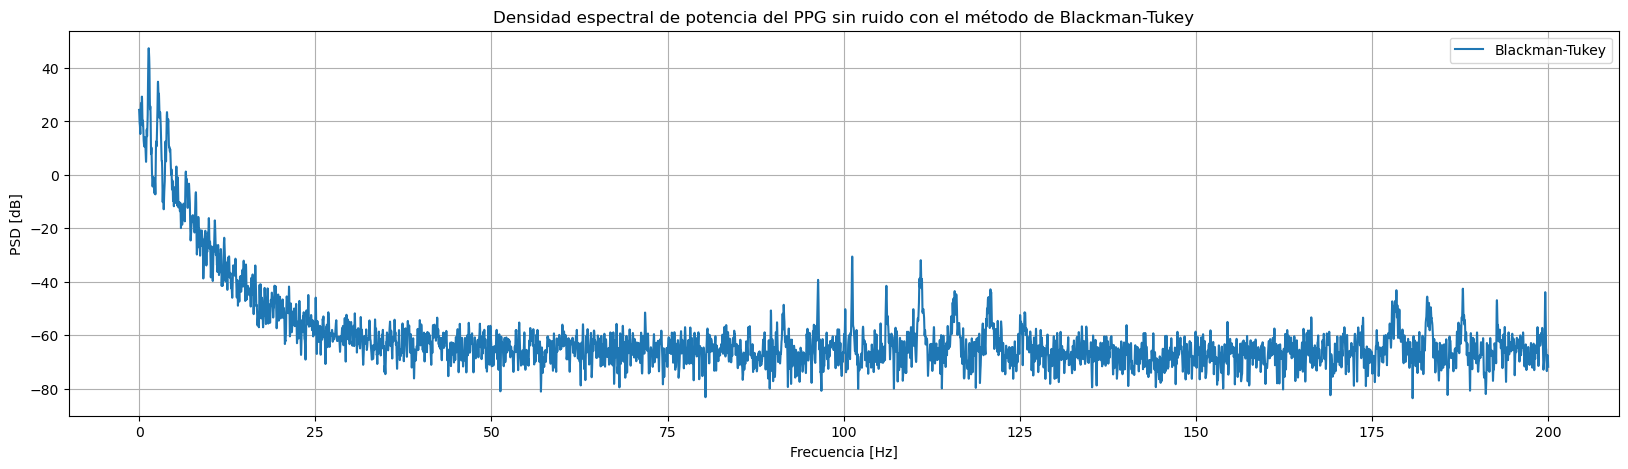

In [82]:
fs_ppg= 400 # Hz
ppg = np.load('ppg_sin_ruido.npy')
N = len(ppg) # Número de muestras
df = fs_ppg/N # Resolución espectral
ff_ppg = np.linspace(0, (N-1)*df, N) # Vector de frecuencias
nor_ppg = ppg / np.std(ppg) # normalizamos el PPG

fw_ppg, Pxxw_ppg = signal.welch(nor_ppg, fs_ppg, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD
Pxxbt_ppg = blackman_tukey(nor_ppg, M=int(N//8)) # uso el metodo de Blackman-Tukey para calcular la PSD
ff_as = ff_ppg[:len(Pxxbt_ppg)//2] # vector de frecuencias para el método de Blackman-Tukey

plt.figure(1,figsize=(20, 5))
plt.plot(nor_ppg, label='PPG sin ruido')
plt.title('PPG sin ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_ppg,10*np.log10(np.abs(Pxxw_ppg)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

plt.figure(3,figsize=(20, 5))
plt.plot(ff_as, 10*np.log10(np.abs(Pxxbt_ppg[:len(Pxxbt_ppg)//2])**2), label='Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

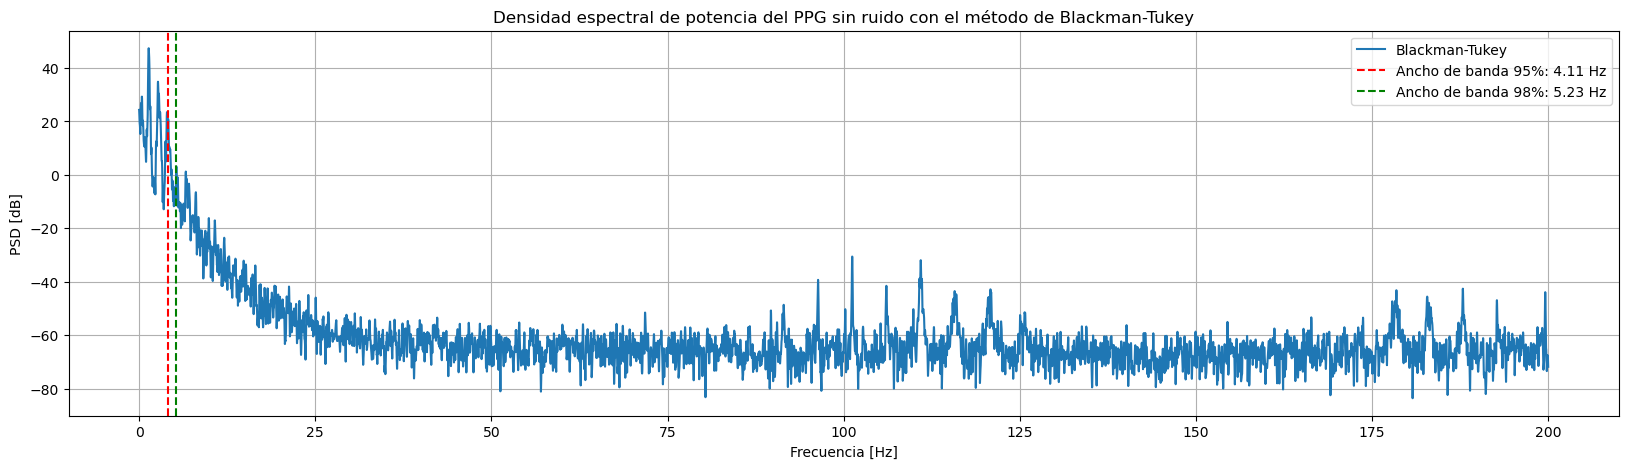

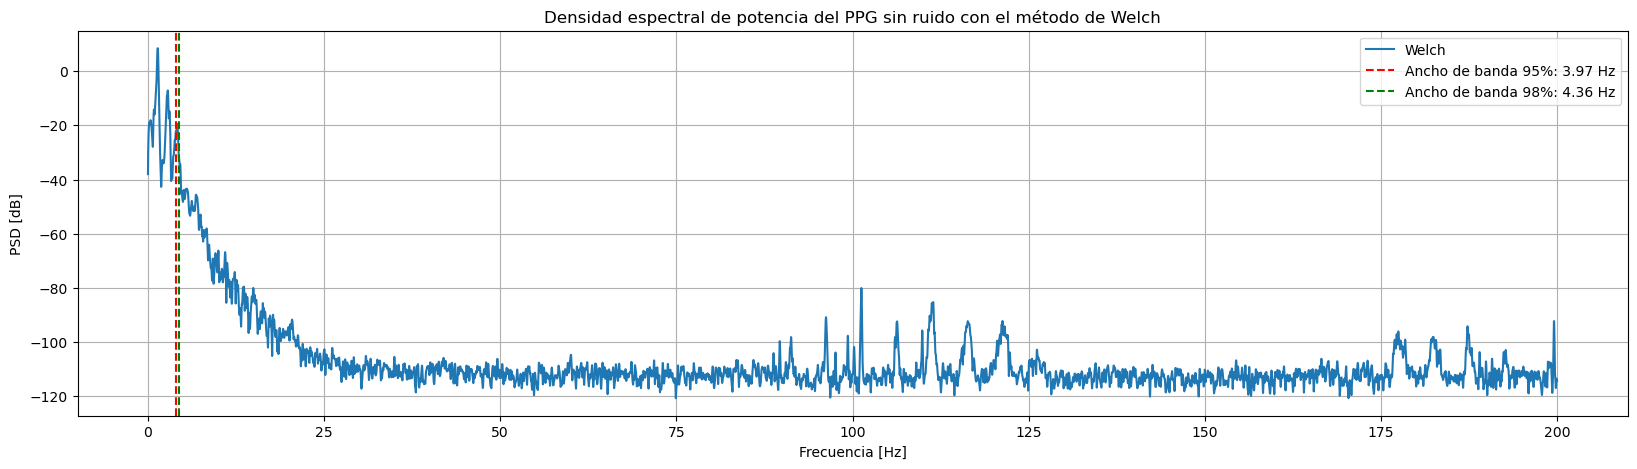

In [83]:
energia_total_bt_ppg=np.sum(Pxxbt_ppg[:len(Pxxbt_ppg)//2]) # La energia total del PPG espectro
energia_acumulada_bt_ppg=np.cumsum(Pxxbt_ppg[:len(Pxxbt_ppg)//2]) # La energia acumulada del PPG espectro
indx_95=np.where(energia_acumulada_bt_ppg>=0.95*energia_total_bt_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
indx_98=np.where(energia_acumulada_bt_ppg>=0.98*energia_total_bt_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
ancho_banda_95_bt_ppg=ff_ppg[indx_95] # El ancho de banda del PPG espectro
ancho_banda_98_bt_ppg=ff_ppg[indx_98] # El ancho de banda del PPG espectro

plt.figure(3,figsize=(20, 5))
plt.plot(ff_as, 10*np.log10(np.abs(Pxxbt_ppg[:len(Pxxbt_ppg)//2])**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_bt_ppg, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_bt_ppg:.2f} Hz')
plt.axvline(x=ancho_banda_98_bt_ppg, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_bt_ppg:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

energia_total_w_ppg=np.sum(Pxxw_ppg) # La energia total del PPG espectro
energia_acumulada_w_ppg=np.cumsum(Pxxw_ppg) # La energia acumulada del PPG espectro
indx_95_w_ppg=np.where(energia_acumulada_w_ppg>=0.95*energia_total_w_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
indx_98_w_ppg=np.where(energia_acumulada_w_ppg>=0.98*energia_total_w_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
ancho_banda_95_w_ppg=ff_ppg[indx_95_w_ppg] # El ancho de banda del PPG espectro
ancho_banda_98_w_ppg=ff_ppg[indx_98_w_ppg] # El ancho de banda del PPG espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_ppg, 10*np.log10(np.abs(Pxxw_ppg)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_ppg, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_ppg:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_ppg, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_ppg:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

# Sonido

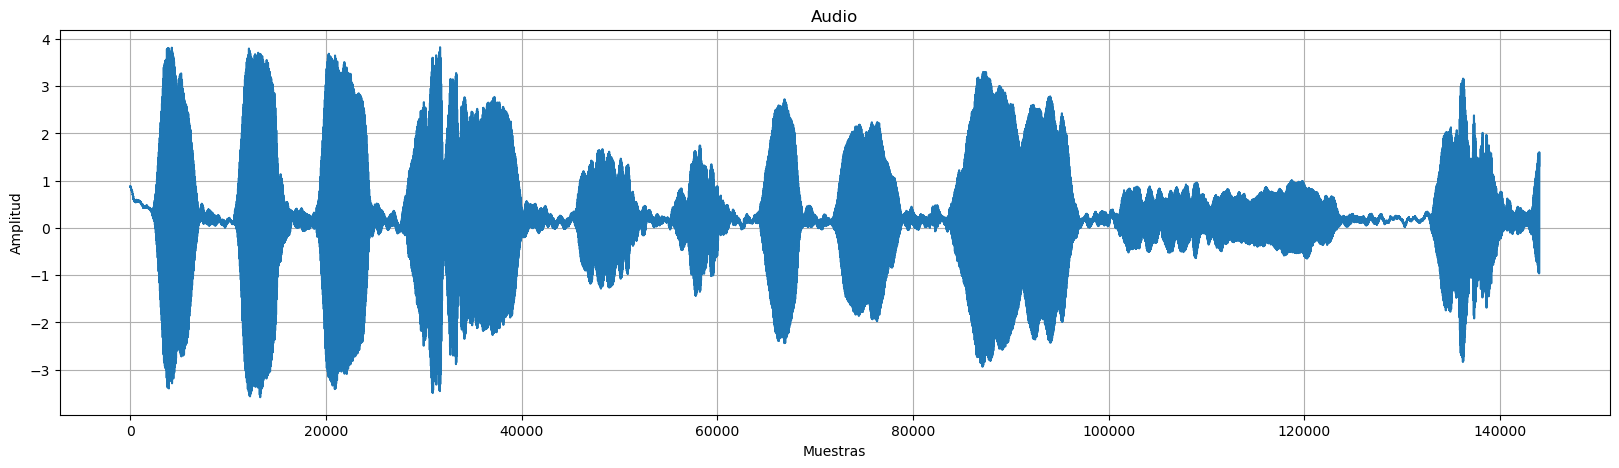

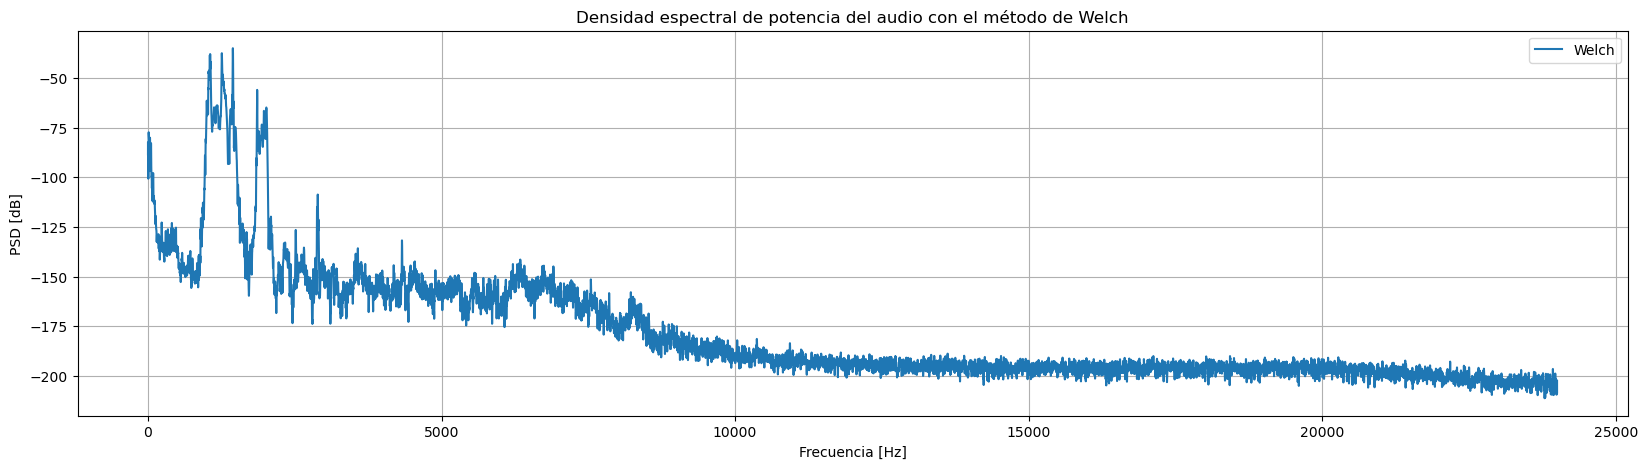

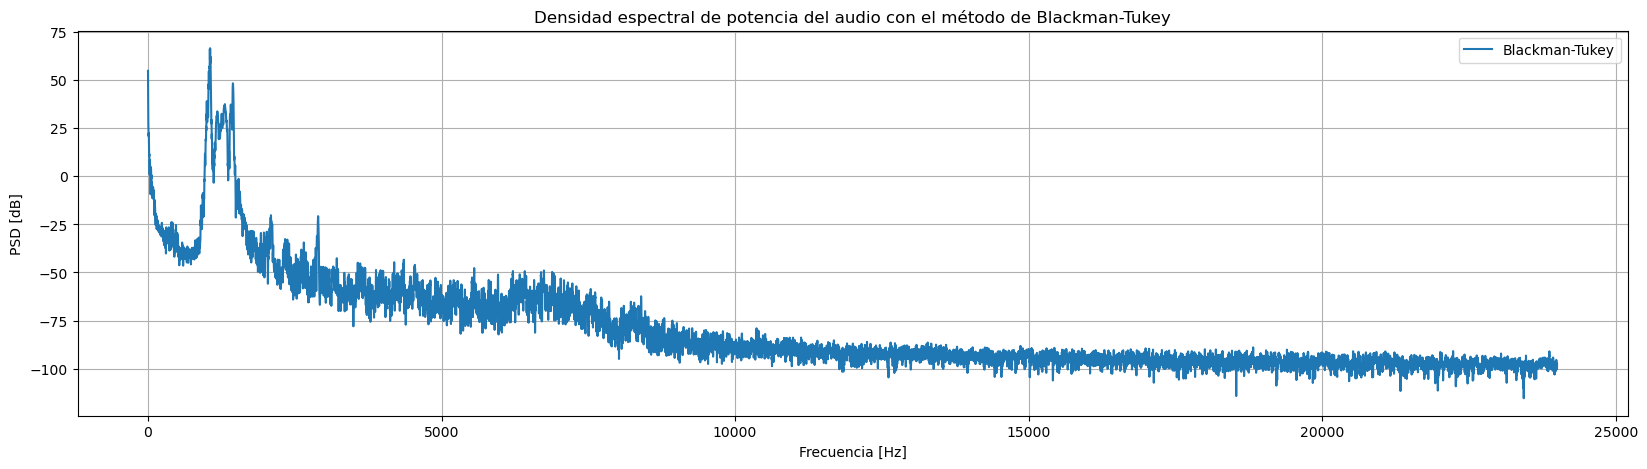

In [84]:
fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
N = len(wav_data) # Número de muestras
df = fs_audio/N # Resolución espectral
ff_audio = np.linspace(0, (N-1)*df, N) # Vector de frecuencias
nor_audio = wav_data / np.std(wav_data) # normalizamos el audio
fw_audio, Pxxw_audio = signal.welch(nor_audio, fs_audio, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD
Pxxbt_audio = blackman_tukey(nor_audio, M=int(N//8)) # uso el metodo de Blackman-Tukey para calcular la PSD
ff_audio = ff_audio[:len(Pxxbt_audio)//2] # vector de frecuencias para el método de Blackman-Tukey

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio)
plt.title('Audio')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio,10*np.log10(np.abs(Pxxw_audio)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio, 10*np.log10(np.abs(Pxxbt_audio[:len(Pxxbt_audio)//2])**2), label='Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

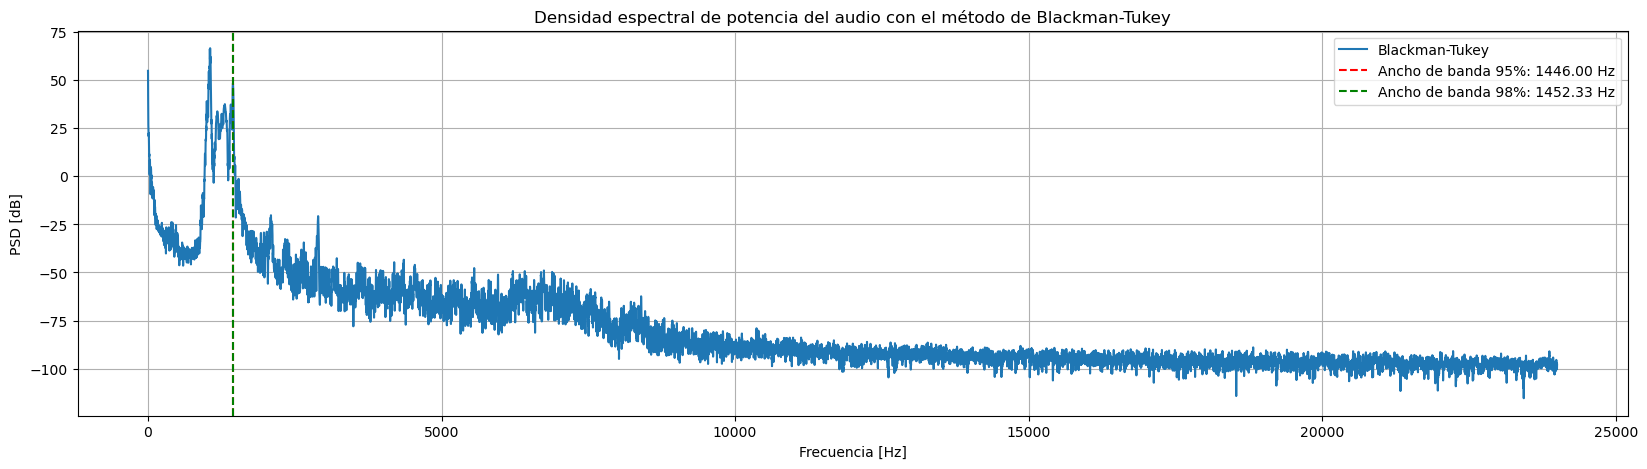

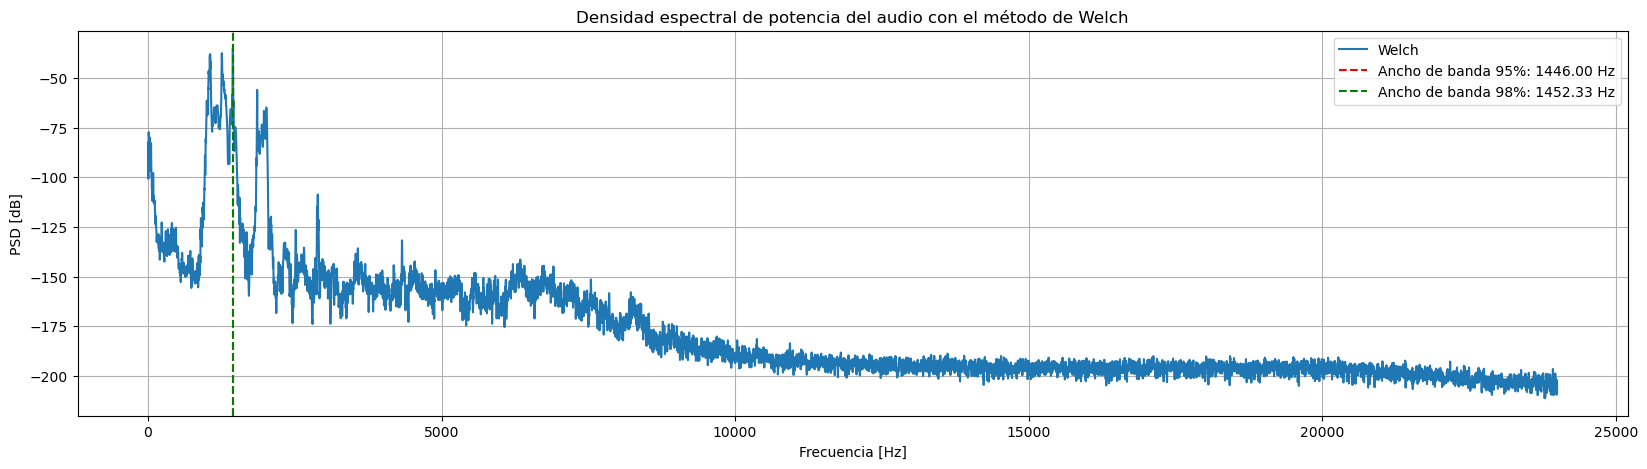

In [85]:
energia_total_bt_audio=np.sum(Pxxbt_audio[:len(Pxxbt_audio)//2]) # La energia total del audio espectro
energia_acumulada_bt_audio=np.cumsum(Pxxbt_audio[:len(Pxxbt_audio)//2]) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_bt_audio>=0.95*energia_total_bt_audio)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_bt_audio>=0.98*energia_total_bt_audio)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_bt_audio=ff_audio[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_bt_audio=ff_audio[indx_98] # El ancho de banda del audio espectro

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio[:len(Pxxbt_audio)//2], 10*np.log10(np.abs(Pxxbt_audio[:len(Pxxbt_audio)//2])**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_bt_audio, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_bt_audio:.2f} Hz')
plt.axvline(x=ancho_banda_98_bt_audio, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_bt_audio:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

energia_total_w_audio=np.sum(Pxxw_audio) # La energia total del audio espectro
energia_acumulada_bt_audio=np.cumsum(Pxxbt_audio) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_bt_audio>=0.95*energia_total_bt_audio)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_bt_audio>=0.98*energia_total_bt_audio)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio=ff_audio[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_w_audio=ff_audio[indx_98] # El ancho de banda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio, 10*np.log10(np.abs(Pxxw_audio)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()


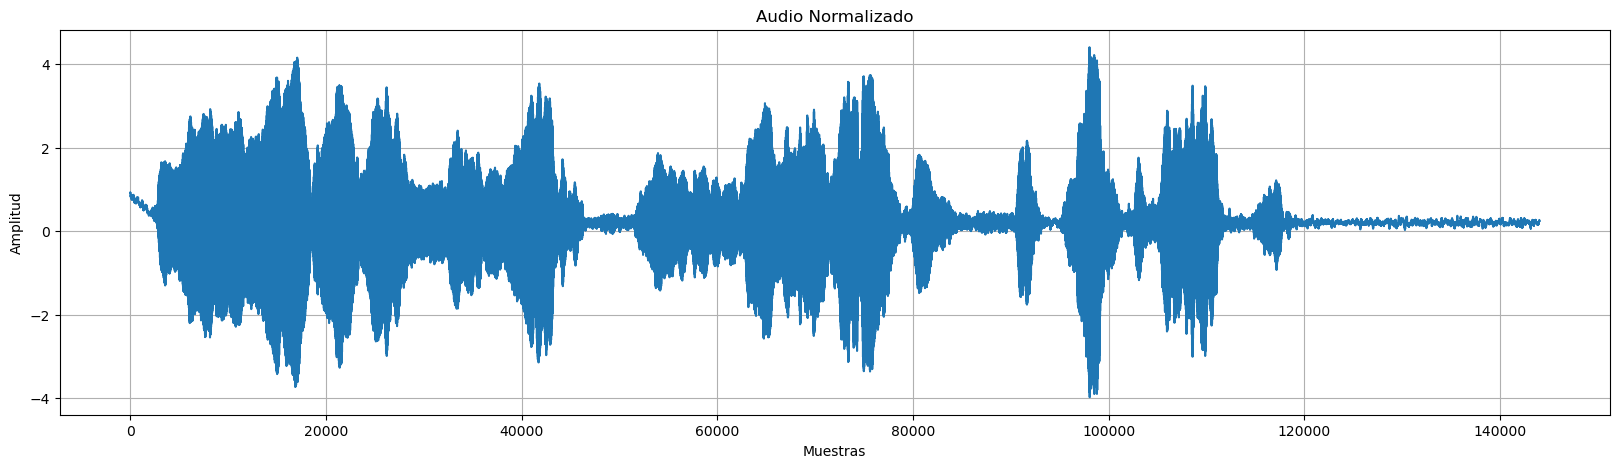

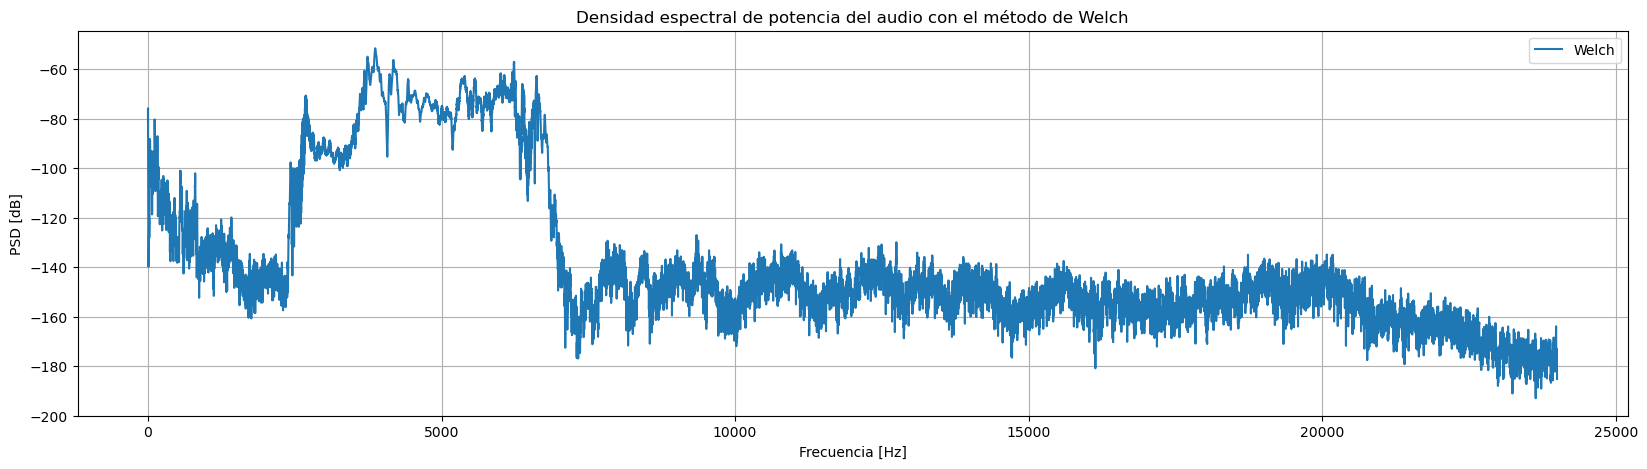

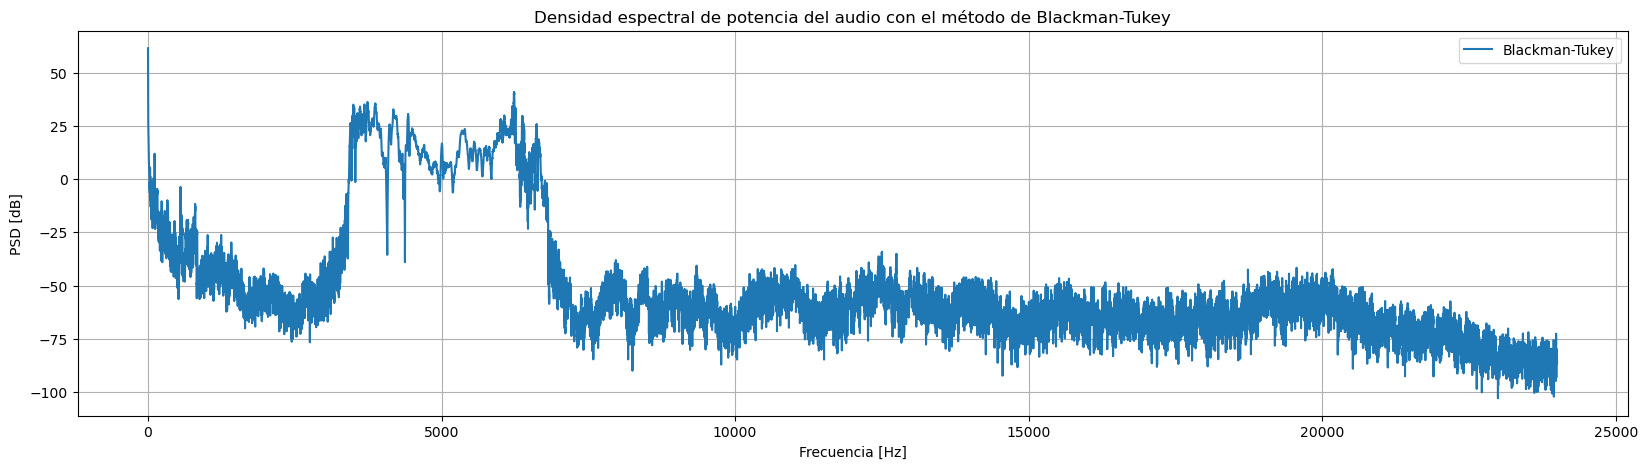

In [86]:
fs_audio_2, wav_data_2 = sio.wavfile.read('silbido.wav')
N = len(wav_data_2) # Número de muestras
df = fs_audio_2/N # Resolución espectral
ff_audio_2 = np.linspace(0, (N-1)*df, N) # Vector de frecuencias
nor_audio_2 = wav_data_2 / np.std(wav_data_2) # normalizamos el audio
fw_audio_2, Pxxw_audio_2 = signal.welch(nor_audio_2, fs_audio_2, nfft=N, window='blackman', nperseg=(N//4), axis=0) # uso el metodo de Welch para calcular la PSD
Pxxbt_audio_2 = blackman_tukey(nor_audio_2, M=int(N//4)) # uso el metodo de Blackman-Tukey para calcular la PSD
ff_audio_2 = ff_audio_2[:len(Pxxbt_audio_2)//2] # vector de frecuencias para el método de Blackman-Tukey

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio_2)
plt.title('Audio Normalizado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio_2,10*np.log10(np.abs(Pxxw_audio_2)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio_2, 10*np.log10(np.abs(Pxxbt_audio_2[:len(Pxxbt_audio_2)//2])**2), label='Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()


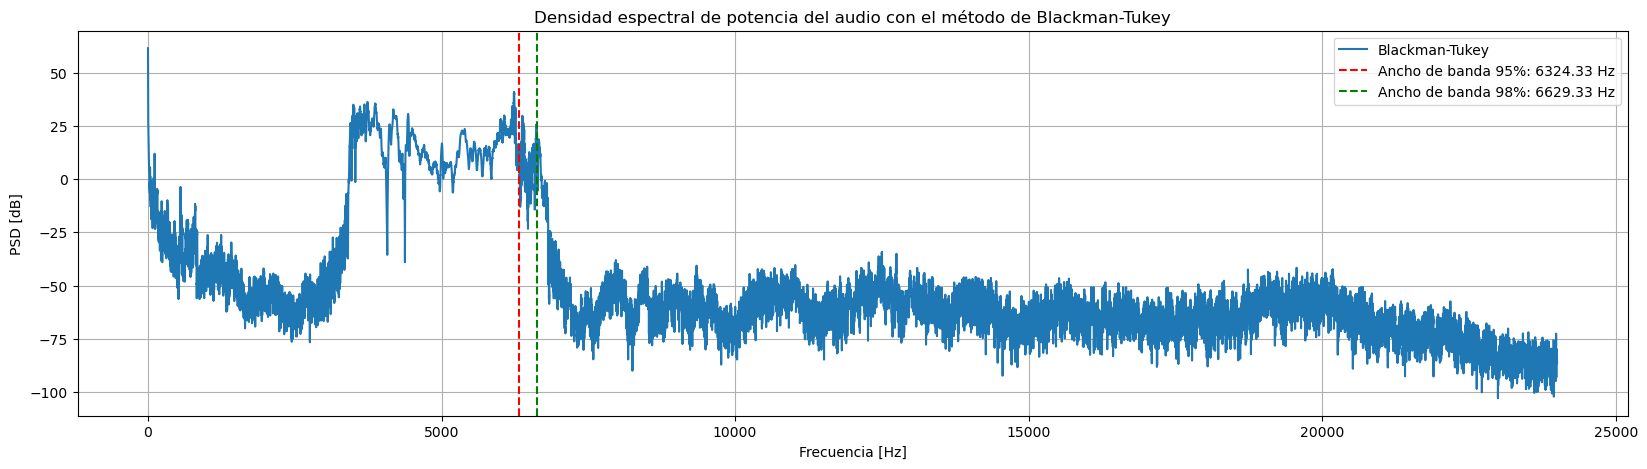

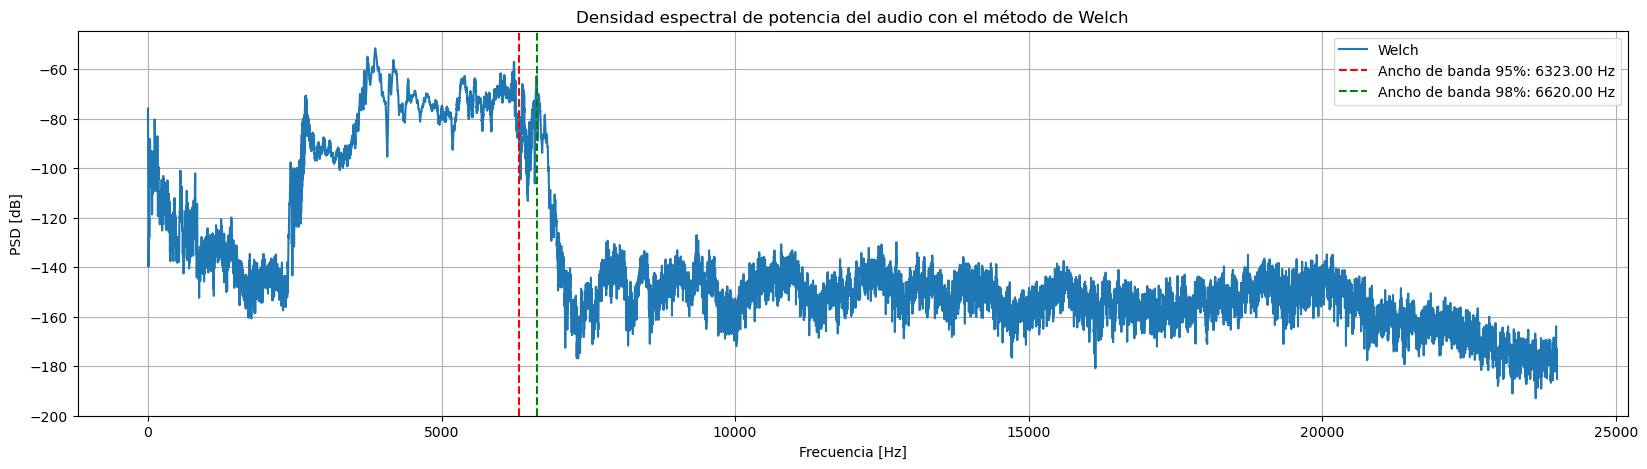

In [87]:
energia_total_bt_audio_2=np.sum(Pxxbt_audio_2[:len(Pxxbt_audio_2)//2]) # La energia total del audio espectro
energia_acumulada_bt_audio_2=np.cumsum(Pxxbt_audio_2[:len(Pxxbt_audio_2)//2]) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_bt_audio_2>=0.95*energia_total_bt_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_bt_audio_2>=0.99*energia_total_bt_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_bt_audio_2=ff_audio_2[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_bt_audio_2=ff_audio_2[indx_98] # El ancho de banda del audio espectro

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio_2[:len(Pxxbt_audio_2)//2], 10*np.log10(np.abs(Pxxbt_audio_2[:len(Pxxbt_audio_2)//2])**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_bt_audio_2, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_bt_audio_2:.2f} Hz')
plt.axvline(x=ancho_banda_98_bt_audio_2, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_bt_audio_2:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

energia_total_w_audio_2=np.sum(Pxxw_audio_2) # La energia total del audio espectro
energia_acumulada_w_audio_2=np.cumsum(Pxxw_audio_2) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_w_audio_2>=0.95*energia_total_w_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_w_audio_2>=0.98*energia_total_w_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio_2=ff_audio_2[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_w_audio_2=ff_audio_2[indx_98] # El ancho de banda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_2, 10*np.log10(np.abs(Pxxw_audio_2)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio_2, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_2:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio_2, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_2:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()


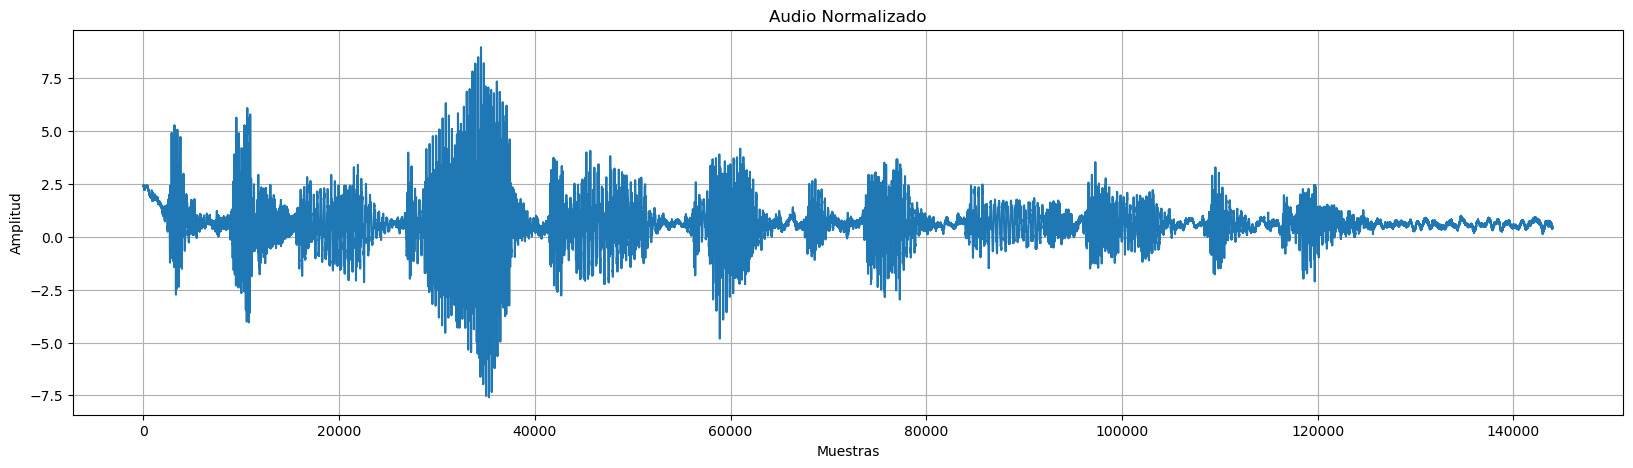

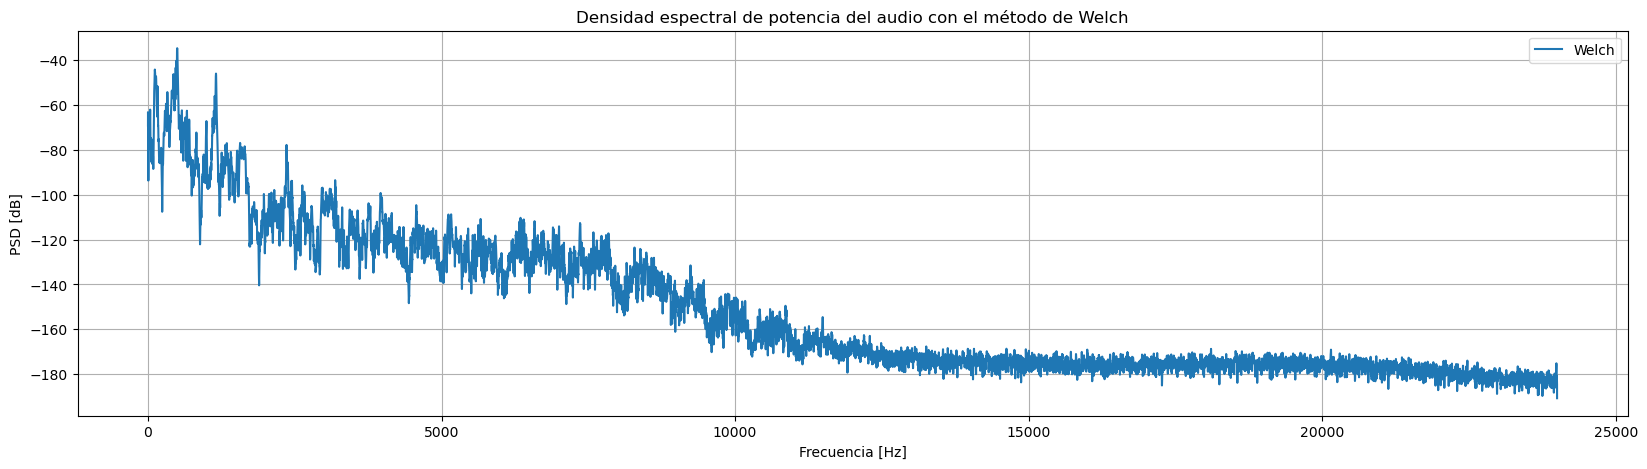

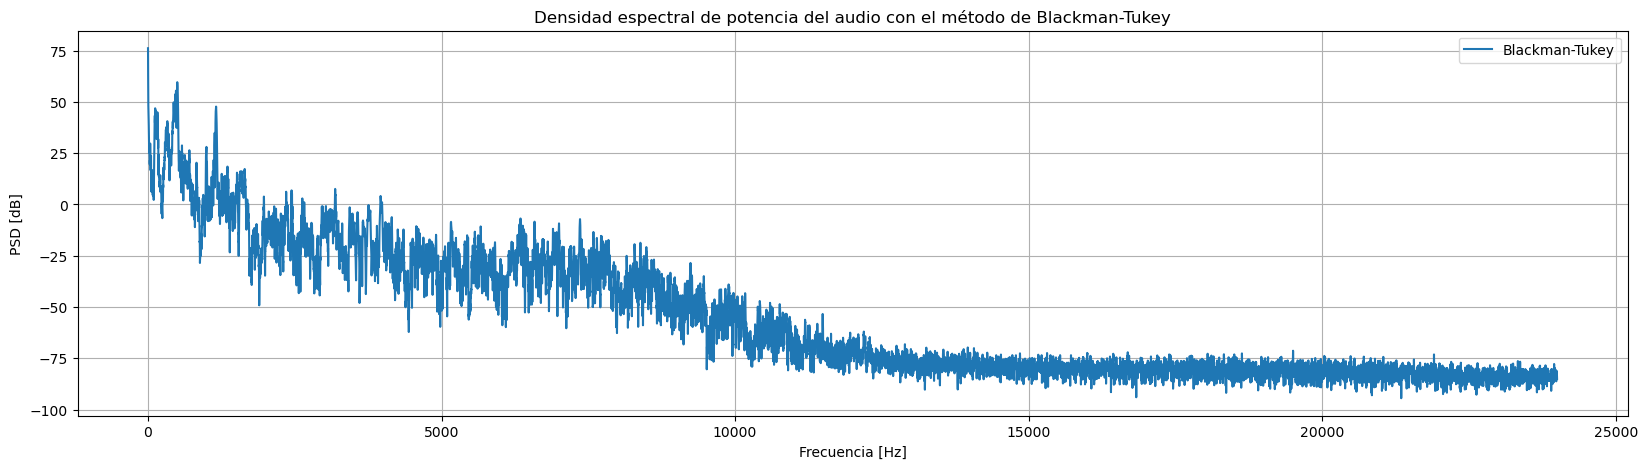

In [88]:
fs_audio_3, wav_data_3 = sio.wavfile.read('prueba psd.wav')
N = len(wav_data_3) # Número de muestras
df = fs_audio_3/N # Resolución espectral
ff_audio_3 = np.linspace(0, (N-1)*df, N) # Vector de frecuencias
nor_audio_3 = wav_data_3 / np.std(wav_data_3) # normalizamos el audio
fw_audio_3, Pxxw_audio_3 = signal.welch(nor_audio_3, fs_audio_3, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD
Pxxbt_audio_3 = blackman_tukey(nor_audio_3, M=int(N//8)) # uso el metodo de Blackman-Tukey para calcular la PSD
ff_audio_3 = ff_audio_3[:len(Pxxbt_audio_3)//2] # vector de frecuencias para el método de Blackman-Tukey

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio_3)
plt.title('Audio Normalizado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio_3,10*np.log10(np.abs(Pxxw_audio_3)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio_3, 10*np.log10(np.abs(Pxxbt_audio_3[:len(Pxxbt_audio_3)//2])**2), label='Blackman-Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

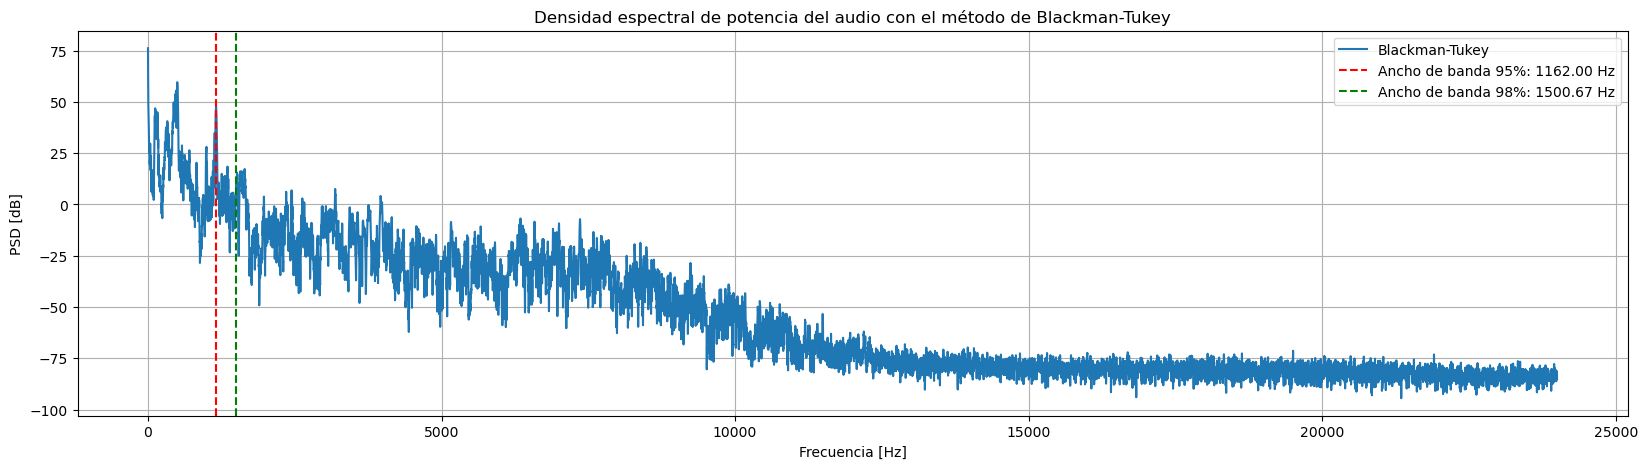

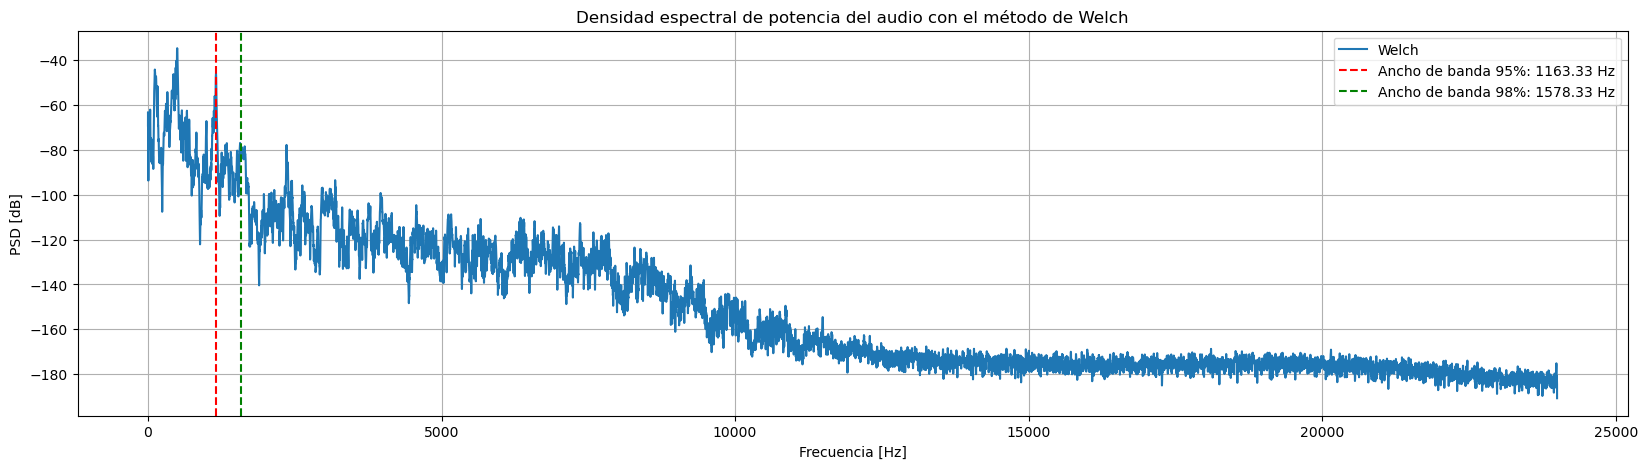

In [89]:
energia_total_bt_audio_3=np.sum(Pxxbt_audio_3[:len(Pxxbt_audio_3)//2]) # La energia total del audio espectro
energia_acumulada_bt_audio_3=np.cumsum(Pxxbt_audio_3[:len(Pxxbt_audio_3)//2]) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_bt_audio_3>=0.95*energia_total_bt_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_bt_audio_3>=0.98*energia_total_bt_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_bt_audio_3=ff_audio_3[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_bt_audio_3=ff_audio_3[indx_98] # El ancho de banda del audio espectro

plt.figure(3,figsize=(20, 5))
plt.plot(ff_audio_3[:len(Pxxbt_audio_3)//2], 10*np.log10(np.abs(Pxxbt_audio_3[:len(Pxxbt_audio_3)//2])**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_bt_audio_3, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_bt_audio_3:.2f} Hz')
plt.axvline(x=ancho_banda_98_bt_audio_3, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_bt_audio_3:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Blackman-Tukey')
plt.grid()
plt.legend()
plt.show()

energia_total_w_audio_3=np.sum(Pxxw_audio_3) # La energia total del audio espectro
energia_acumulada_w_audio_3=np.cumsum(Pxxw_audio_3) # La energia acumulada del audio espectro
indx_95=np.where(energia_acumulada_w_audio_3>=0.95*energia_total_w_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
indx_98=np.where(energia_acumulada_w_audio_3>=0.98*energia_total_w_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio_3=ff_audio_3[indx_95] # El ancho de banda del audio espectro
ancho_banda_98_w_audio_3=ff_audio_3[indx_98] # El ancho de banda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_3, 10*np.log10(np.abs(Pxxw_audio_3)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio_3, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_3:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio_3, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_3:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()


In [90]:

# Crear la tabla con los valores obtenidos previamente
datos = {
    'Señal': [
        'ECG', 'ECG',
        'PPG', 'PPG',
        'Audio 1', 'Audio 1',
        'Audio 2', 'Audio 2',
        'Audio 3', 'Audio 3'
    ],
    'Método': [
        'Welch', 'Blackman-Tukey',
        'Welch', 'Blackman-Tukey',
        'Welch', 'Blackman-Tukey',
        'Welch', 'Blackman-Tukey',
        'Welch', 'Blackman-Tukey'
    ],
    'Ancho de banda 95% (Hz)': [
        ancho_banda_95_ecg_w, ancho_banda_95_ecg_bt,
        ancho_banda_95_w_ppg, ancho_banda_95_bt_ppg,
        ancho_banda_95_w_audio, ancho_banda_95_bt_audio,
        ancho_banda_95_w_audio_2, ancho_banda_95_bt_audio_2,
        ancho_banda_95_w_audio_3, ancho_banda_95_bt_audio_3
    ],
    'Ancho de banda 98% (Hz)': [
        ancho_banda_98_ecg_w, ancho_banda_98_ecg_bt,
        ancho_banda_98_w_ppg, ancho_banda_98_bt_ppg,
        ancho_banda_98_w_audio, ancho_banda_98_bt_audio,
        ancho_banda_98_w_audio_2, ancho_banda_98_bt_audio_2,
        ancho_banda_98_w_audio_3, ancho_banda_98_bt_audio_3
    ]
}

tabla = pd.DataFrame(datos)
tabla['Ancho de banda 95% (Hz)'] = tabla['Ancho de banda 95% (Hz)'].round(2)
tabla['Ancho de banda 98% (Hz)'] = tabla['Ancho de banda 98% (Hz)'].round(2)
display(tabla)

,Señal,Método,Ancho de banda 95% (Hz),Ancho de banda 98% (Hz)
0,ECG,Welch,23.40,27.77
1,ECG,Blackman-Tukey,24.03,28.40
2,PPG,Welch,3.97,4.36
3,PPG,Blackman-Tukey,4.11,5.23
4,Audio 1,Welch,1446.00,1452.33
5,Audio 1,Blackman-Tukey,1446.00,1452.33
6,Audio 2,Welch,6323.00,6620.00
7,Audio 2,Blackman-Tukey,6324.33,6629.33
8,Audio 3,Welch,1163.33,1578.33
9,Audio 3,Blackman-Tukey,1162.00,1500.67


#

# Analisis: 
En principio podemos notar la poca diferencia que hay entre los distintos metodos empleados en igualdad de condiciones y terminos usados.
Mirando el grafico de la densidad espectral de potencial del ECG, se ve como la potencia esta en concentrada en el intervalo (0.5,40)Hz aproximadamente, nuestra estimacion calculada a traves de encontrar el area total y el punto que delimita el 95% y 98% del espectro, nos da un resultado alejado del extremo del intervalo que se le puede atribuir al poco ruido que presenta la señal, teniendo un caida de potencia con un parecido a una exponencial negativa.
Siguiendo con el PPG su energia se halla en un intervalo aproximado al de (0.5,10)Hz y en nuestra estimacion vemos como tambien se encuentra alejada, tiene caracteristicas muy similares a la de un ECG solo que en un intervalo mas chico.